In [14]:
!pip install  lightgbm catboost seaborn

Looking in indexes: http://mirror.ca.sbrf.ru/pypi/simple


In [5]:
pip list

Package                           Version
--------------------------------- ----------------
absl-py                           1.0.0
aiohttp                           3.8.1
aiosignal                         1.2.0
alembic                           1.4.1
anyio                             3.3.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
astroid                           2.9.3
astunparse                        1.6.3
async-generator                   1.10
async-timeout                     4.0.2
asynctest                         0.13.0
attrs                             21.2.0
autopep8                          1.6.0
Babel                             2.9.1
backcall                          0.2.0
bash_kernel                       0.7.2
bleach                            4.1.0
bokeh                             2.3.3
cachetools                        4.2.4
catboost                          1.0.4
certifi                           2021.10.8
certipy             

In [15]:
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook 
import datetime as dt
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgbm
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_column', None)
tqdm_notebook.pandas()

In [16]:
data = pd.read_csv('dataset_1.csv', index_col=0, thousands=',')

In [78]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13397810 entries, 0 to 13397809
Data columns (total 25 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   ID_Operation_History    13397810 non-null  int64  
 1   date_report             13397810 non-null  int64  
 2   emploee_position        13397810 non-null  object 
 3   emp_age                 13397810 non-null  float64
 4   report-start_job        13397810 non-null  int64  
 5   finish_job-report       13397810 non-null  int64  
 6   SOURCE_SYSTEM           13397810 non-null  object 
 7   OPERATION               13397810 non-null  object 
 8   CHANNEL_GR              13397810 non-null  object 
 9   urf_code_uni            13397810 non-null  object 
 10  QUANTITY                13397810 non-null  int64  
 11  DESCRIPTION             13397810 non-null  object 
 12  IN_MOTIV                13397810 non-null  int64  
 13  PRODUCT_NAME            13397810 non-nul

In [130]:
cat_features = ['emploee_position', 'SOURCE_SYSTEM', 'OPERATION', 'CHANNEL_GR', 'urf_code_uni', 'PRODUCT_NAME', 'day_of_week', 'IN_MOTIV']
#  'DESCRIPTION', 'IN_MOTIV'

In [81]:
num_features = ['date_report', 'emp_age', 'report-start_job', 'finish_job-report', 'QUANTITY', 'vl_up', 'insert-report', 'update-report', 'client_age',
                'client_is_emploee', 'emploee_in_vacation', 'emp_oper_per_day', 'emp_oper_per_month', 'client_product_per_day']

In [82]:
data['emp_oper_per_day'] = data['emp_oper_per_day'].fillna(0)
data['emp_oper_per_month'] = data['emp_oper_per_month'].fillna(0)
data['client_product_per_day'] = data['client_product_per_day'].fillna(0)

In [83]:
data = data.dropna()

In [84]:
data['target'] = np.where(data['target'] != 0, 1, 0)

In [86]:
data['target'].value_counts()

0    12026941
1     1323440
Name: target, dtype: int64

In [9]:
data.head(0)

,ID_Operation_History,date_report,emploee_position,emp_age,report-start_job,finish_job-report,SOURCE_SYSTEM,OPERATION,CHANNEL_GR,urf_code_uni,QUANTITY,DESCRIPTION,IN_MOTIV,PRODUCT_NAME,vl_up,insert-report,update-report,client_age,client_is_emploee,emploee_in_vacation,emp_oper_per_day,emp_oper_per_month,day_of_week,client_product_per_day,target


# Ridge and OrdinalEncoder

In [39]:
dfR = data

In [40]:
enc = OrdinalEncoder()

In [43]:
enc.fit(dfR[['emploee_position', 'SOURCE_SYSTEM', 'OPERATION', 'CHANNEL_GR', 'urf_code_uni', 'DESCRIPTION', 'PRODUCT_NAME', 'day_of_week']])

OrdinalEncoder()

In [44]:
dfR[['emploee_position', 'SOURCE_SYSTEM', 'OPERATION', 'CHANNEL_GR',
      'urf_code_uni', 'DESCRIPTION', 'PRODUCT_NAME', 'day_of_week']] = enc.fit_transform(
    dfR[['emploee_position', 'SOURCE_SYSTEM', 'OPERATION', 'CHANNEL_GR',
      'urf_code_uni', 'DESCRIPTION', 'PRODUCT_NAME', 'day_of_week']])

In [45]:
dfR.head()

,ID_Operation_History,date_report,emploee_position,emp_age,report-start_job,finish_job-report,SOURCE_SYSTEM,OPERATION,CHANNEL_GR,urf_code_uni,QUANTITY,DESCRIPTION,IN_MOTIV,PRODUCT_NAME,vl_up,insert-report,update-report,client_age,client_is_emploee,emploee_in_vacation,emp_oper_per_day,emp_oper_per_month,day_of_week,client_product_per_day,target
0,25664113,9,19.0,35.904110,831,13,11.0,95.0,2.0,67.0,100,93.0,1,96.0,4,93,51,37.347945,0,0,14.0,265.0,1.0,3.0,0
1,25664134,18,76.0,20.972603,110,87794,9.0,104.0,2.0,663.0,100,93.0,1,19.0,5,84,42,30.476712,0,1,27.0,416.0,6.0,1.0,0
2,25664157,13,76.0,34.334247,556,32,9.0,95.0,2.0,676.0,100,93.0,1,95.0,24,89,47,54.975342,0,0,21.0,574.0,0.0,4.0,0
3,25664169,17,22.0,33.484932,42,64,9.0,115.0,2.0,1188.0,100,93.0,3,115.0,0,85,43,69.832877,0,0,30.0,520.0,5.0,9.0,0
4,25664176,23,79.0,54.564384,2149,4,9.0,95.0,2.0,443.0,100,93.0,1,95.0,24,79,37,44.830137,0,0,10.0,314.0,1.0,6.0,0


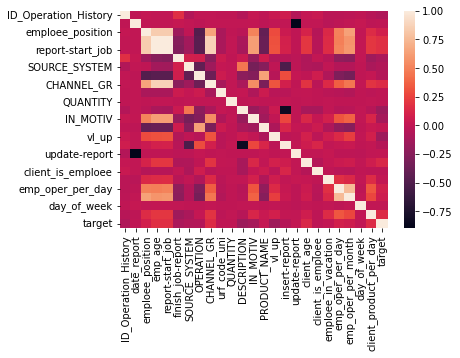

In [74]:
sns.heatmap(dfR.corr());

In [46]:
X = dfR.drop(['target', 'ID_Operation_History'], axis=1)
y = dfR['target']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [48]:
y_train.value_counts()

0    7215740
1     794488
Name: target, dtype: int64

In [49]:
y_test.value_counts()

0    4811201
1     528952
Name: target, dtype: int64

In [50]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes, y_train)
class_weights = dict(zip(classes, weights))

In [51]:
ridge = RidgeClassifier(class_weight=class_weights)

In [52]:
ridge.fit(X_train, y_train)

RidgeClassifier(class_weight={0: 0.5550524270552986, 1: 5.041125857155803})

In [54]:
ridge.score(X_test, y_test)

0.9169420801239215

In [55]:
ridge.score(X_train, y_train)

0.9167205977158204

In [57]:
preds = ridge.predict(X_test)

In [58]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95   4811201
           1       0.55      0.93      0.69    528952

    accuracy                           0.92   5340153
   macro avg       0.77      0.92      0.82   5340153
weighted avg       0.95      0.92      0.93   5340153



# Try Random Forest and get_dummies

In [18]:
df1 = pd.get_dummies(data[cat_features[:6]], drop_first=True)

Посмотрела на количество части векторизованных категориальных признаков и стало грустно(((

Перейдём, пожалуй, сразу к CatBoost

In [ ]:
data[num_features]

# Try CatBoost

In [ ]:
X = data.drop(['target', 'ID_Operation_History', 'DESCRIPTION'], axis=1)
y = data['target']

In [10]:
X.head(0)

NameError: name 'X' is not defined

In [133]:
X.shape

(13350381, 22)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)

In [135]:
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes, y_train)
class_weights = dict(zip(classes, weights))

In [136]:
cat_features

['emploee_position',
 'SOURCE_SYSTEM',
 'OPERATION',
 'CHANNEL_GR',
 'urf_code_uni',
 'PRODUCT_NAME',
 'day_of_week',
 'IN_MOTIV']

In [137]:
train_dataset = Pool(X_train, y_train, cat_features=cat_features)
test_dataset = Pool(X_test, y_test, cat_features=cat_features)

In [138]:
clf = CatBoostClassifier(class_weights=class_weights, task_type='GPU')

In [139]:
clf.fit(X_train, y_train, cat_features=cat_features, verbose=10)

Learning rate set to 0.020562
0:	learn: 0.6155852	total: 370ms	remaining: 6m 9s
10:	learn: 0.2022420	total: 4.06s	remaining: 6m 5s
20:	learn: 0.0925409	total: 7.85s	remaining: 6m 5s
30:	learn: 0.0541104	total: 11.8s	remaining: 6m 9s
40:	learn: 0.0393014	total: 15.6s	remaining: 6m 5s
50:	learn: 0.0335502	total: 19.7s	remaining: 6m 6s
60:	learn: 0.0296332	total: 23.7s	remaining: 6m 4s
70:	learn: 0.0275608	total: 27.6s	remaining: 6m
80:	learn: 0.0256266	total: 31.5s	remaining: 5m 57s
90:	learn: 0.0238553	total: 35.4s	remaining: 5m 54s
100:	learn: 0.0227564	total: 39.1s	remaining: 5m 48s
110:	learn: 0.0220451	total: 42.9s	remaining: 5m 43s
120:	learn: 0.0214136	total: 46.5s	remaining: 5m 38s
130:	learn: 0.0208881	total: 50.3s	remaining: 5m 33s
140:	learn: 0.0205153	total: 54.2s	remaining: 5m 30s
150:	learn: 0.0202240	total: 58s	remaining: 5m 26s
160:	learn: 0.0199951	total: 1m 1s	remaining: 5m 22s
170:	learn: 0.0198123	total: 1m 5s	remaining: 5m 19s
180:	learn: 0.0196509	total: 1m 9s	remai

In [140]:
clf.score(X_train, y_train)

0.9936340139132119

In [141]:
clf.score(X_test, y_test)

0.9936462494613918

In [142]:
pred = clf.predict(X_test)

In [143]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   4811201
           1       0.95      0.99      0.97    528952

    accuracy                           0.99   5340153
   macro avg       0.97      0.99      0.98   5340153
weighted avg       0.99      0.99      0.99   5340153



In [144]:
data[data['target'] == 1]['IN_MOTIV'].value_counts()

 0    1204799
-1      69273
 1      42079
 3       7207
 2         82
Name: IN_MOTIV, dtype: int64

In [ ]:
X_test[]

In [146]:
clf.feature_names_

['date_report',
 'emploee_position',
 'emp_age',
 'report-start_job',
 'finish_job-report',
 'SOURCE_SYSTEM',
 'OPERATION',
 'CHANNEL_GR',
 'urf_code_uni',
 'QUANTITY',
 'IN_MOTIV',
 'PRODUCT_NAME',
 'vl_up',
 'insert-report',
 'update-report',
 'client_age',
 'client_is_emploee',
 'emploee_in_vacation',
 'emp_oper_per_day',
 'emp_oper_per_month',
 'day_of_week',
 'client_product_per_day']

In [147]:
features = pd.DataFrame({'feature_importance': clf.get_feature_importance(),
                         'feature_names': clf.feature_names_}).sort_values(by=['feature_importance'], ascending=False)

In [148]:
features

,feature_importance,feature_names
10,22.610164,IN_MOTIV
11,16.881913,PRODUCT_NAME
5,12.935667,SOURCE_SYSTEM
12,10.254963,vl_up
6,9.721966,OPERATION
13,7.606412,insert-report
21,4.771862,client_product_per_day
15,2.391453,client_age
16,2.047365,client_is_emploee
1,2.030087,emploee_position


In [88]:
data['DESCRIPTION'].unique()

array(['Операция принята к учету', 'Операция премируется',
       'Не премируются операция выдачи карт Моментум, премируется только оформление заявления на карты Моментум',
       'без предложения CRM/Iserve',
       'Не премируется. Оплачивается платеж/перевод по сумме от 100 руб. 00 коп.',
       'Не премируется, более 8 продаж в день',
       'Не премируется. Клиентом не проведена оплата подписки ',
       'Не премируется, отсутствует обработка CRM/ISERV (согласно правил учёта УП)',
       '-',
       'Не премируется . Оплачиваются справки/выписки, оформленные по талону С (до июля 2021) или Э (с августа 2021) корректно заведенные в AC CRM  иили АС Целевой подбор СБОЛ.Про с указанием первичной потребности "Выписки и справки"     ',
       'Не премируется. Оплачивается не более одного продукта в день на 1-го клиента.',
       'Не премируется, клиент уже пользовался СБОЛ/МП ранее.',
       'Превышено кол-во продаж на месяц без спецпредложения в CRM',
       'Установка без осуществления